In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 2.7MB/s 


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
!pip install -U spectral


if not (os.path.isfile('/content/Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('/content/Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

     |████████████████████████████████| 194kB 2.7MB/s 
--2020-04-30 14:22:06--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   266KB/s    in 22s     

2020-04-30 14:22:29 (264 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-04-30 14:22:32--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s   

In [0]:
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F

In [0]:
import scipy.io as sio
def loadData():
    data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [0]:
class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self,data_url,label_url):
        
        self.data = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])[data_url.split('/')[-1].split('.')[0].lower()])
        self.targets = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])[label_url.split('/')[-1].split('.')[0].lower()])
        self.data, self.targets = createImageCubes(self.data,self.targets, windowSize=5)
        
        
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0,3,1,2)
        print(self.data.shape)
        

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
      
      return self.data[idx,:,:,:] , self.targets[idx]


In [0]:
data_train = HyperSpectralDataset('Indian_pines_corrected.mat','Indian_pines_gt.mat')

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

torch.Size([10249, 200, 5, 5])


In [0]:
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())

torch.Size([200, 5, 5])
10249


In [0]:
class PAM_Module(Module):
    """ Position attention module  https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        
        return out


class CAM_Module(Module):
    """ Channel attention module https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    def __init__(self):
        super(CAM_Module, self).__init__()
        #self.chanel_in = in_dim
        
        


        self.gamma = Parameter(torch.zeros(1))
        self.softmax  = Softmax(dim=-1)
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        #out = self.last_conv(out)
        
        
        return out


In [0]:
class RecNet(nn.Module):
    def __init__(self):
        super(RecNet, self).__init__()
        self.conv3d_1 = nn.Sequential(nn.Conv3d(1, 128, (1, 3, 3), 1), 
                        nn.BatchNorm3d(128),
                        nn.PReLU())
        
        self.conv3d_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 3, 3), 1),
                        nn.BatchNorm3d(64),
                        nn.PReLU())
                        
        
        self.pool3d = nn.MaxPool3d((1, 1, 1), (1, 1, 1))
        
        self.deconv3d_1 = nn.Sequential(nn.ConvTranspose3d(64, 128, (1, 3, 3), 1),
                          nn.BatchNorm3d(128),
                          nn.PReLU())
        
        self.deconv3d_2 = nn.Sequential(nn.ConvTranspose3d(128, 1, (1, 3, 3), 1),
                          nn.BatchNorm3d(1))
        

    def forward(self, x):
        x = self.conv3d_1(x)
        x = self.conv3d_2(x)
        
        x = self.pool3d(x)
        
        x = self.deconv3d_1(x)
        x = self.deconv3d_2(x)
        
        
        return x.squeeze(1)

In [0]:
"""class RecNet_old(nn.Module):
    def __init__(self):
        super(RecNet_old, self).__init__()
        self.conv3d_1 = nn.Sequential(nn.Conv3d(1, 24, (24, 3, 3), 1),
                        nn.BatchNorm3d(24),
                        nn.PReLU())
        
        self.conv3d_2 = nn.Sequential(nn.Conv3d(24, 48, (24, 3, 3), 1),
                        nn.BatchNorm3d(48),
                        nn.PReLU())
                        
        
        self.pool3d = nn.MaxPool3d((18, 1, 1), (18, 1, 1))
        
        self.deconv3d_1 = nn.Sequential(nn.ConvTranspose3d(48, 24, (9, 3, 3), (22, 1, 1)),
                          nn.BatchNorm3d(24),
                          nn.PReLU())
        
        self.deconv3d_2 = nn.Sequential(nn.ConvTranspose3d(24, 1, (38, 3, 3), (1, 1, 1)),
                          nn.BatchNorm3d(1))

    def forward(self, x):
        x = self.conv3d_1(x)
        x = self.conv3d_2(x)
        
        x = self.pool3d(x)
        
        x = self.deconv3d_1(x)
        x = self.deconv3d_2(x)
        
        return x.squeeze(1)"""

'class RecNet_old(nn.Module):\n    def __init__(self):\n        super(RecNet_old, self).__init__()\n        self.conv3d_1 = nn.Sequential(nn.Conv3d(1, 24, (24, 3, 3), 1),\n                        nn.BatchNorm3d(24),\n                        nn.PReLU())\n        \n        self.conv3d_2 = nn.Sequential(nn.Conv3d(24, 48, (24, 3, 3), 1),\n                        nn.BatchNorm3d(48),\n                        nn.PReLU())\n                        \n        \n        self.pool3d = nn.MaxPool3d((18, 1, 1), (18, 1, 1))\n        \n        self.deconv3d_1 = nn.Sequential(nn.ConvTranspose3d(48, 24, (9, 3, 3), (22, 1, 1)),\n                          nn.BatchNorm3d(24),\n                          nn.PReLU())\n        \n        self.deconv3d_2 = nn.Sequential(nn.ConvTranspose3d(24, 1, (38, 3, 3), (1, 1, 1)),\n                          nn.BatchNorm3d(1))\n\n    def forward(self, x):\n        x = self.conv3d_1(x)\n        x = self.conv3d_2(x)\n        \n        x = self.pool3d(x)\n        \n        x = s

In [0]:
class DANet(Module):
  def __init__(self):
    super(DANet,self).__init__()
    self.PAM_Module = PAM_Module(200)
    self.CAM_Module = CAM_Module()
    self.RecNet = RecNet()
  def forward(self,x):
    
    P = self.PAM_Module(x)
    C = self.CAM_Module(x)
    #B,Ch,H,W = P.size()
    J = P + C
    J =  J.unsqueeze(1)
    ret = self.RecNet(J)
    
    
    
    return ret
    
    
danet_model = DANet().to(device)

In [0]:

from torchsummary import summary
summary(danet_model,input_size=(200,5,5))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 25, 5, 5]           5,025
            Conv2d-2             [-1, 25, 5, 5]           5,025
           Softmax-3               [-1, 25, 25]               0
            Conv2d-4            [-1, 200, 5, 5]          40,200
        PAM_Module-5            [-1, 200, 5, 5]               0
           Softmax-6             [-1, 200, 200]               0
        CAM_Module-7            [-1, 200, 5, 5]               0
            Conv3d-8       [-1, 128, 200, 3, 3]           1,280
       BatchNorm3d-9       [-1, 128, 200, 3, 3]             256
            PReLU-10       [-1, 128, 200, 3, 3]               1
           Conv3d-11        [-1, 64, 200, 1, 1]          73,792
      BatchNorm3d-12        [-1, 64, 200, 1, 1]             128
            PReLU-13        [-1, 64, 200, 1, 1]               1
        MaxPool3d-14        [-1, 64, 20

In [0]:
#!pip install git+https://github.com/IssamLaradji/sps.git

In [0]:
"""import sps
optimizer = sps.Sps(danet_model.parameters())"""

'import sps\noptimizer = sps.Sps(danet_model.parameters())'

In [0]:
#model = BSNET_Conv().to(device) 

optimizer = optim.SGD(danet_model.parameters(), lr=0.01, momentum=0.9)

In [0]:
top = 25

In [0]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIM(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(200)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,200):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 50):
    train(epoch)
    

Train Epoch: 0 [0/10249 (0%)]	Loss: 116.609062
SSIM: 0.49996912479400635
PSNR: 25.032970428466797
Top 25 bands with Entropy -> [155, 67, 197, 35, 143, 1, 145, 30, 176, 51, 0, 26, 69, 13, 73, 97, 70, 40, 45, 65, 63, 114, 47, 36, 18]
Train Epoch: 1 [0/10249 (0%)]	Loss: 66.218239
SSIM: 0.3548260033130646
PSNR: 28.71985626220703
Top 25 bands with Entropy -> [174, 102, 109, 195, 36, 151, 148, 143, 23, 48, 145, 177, 157, 196, 122, 41, 136, 173, 150, 175, 170, 194, 77, 169, 104]
Train Epoch: 2 [0/10249 (0%)]	Loss: 26.217543
SSIM: 0.11294196546077728
PSNR: 35.449649810791016
Top 25 bands with Entropy -> [81, 164, 91, 34, 136, 126, 166, 17, 190, 189, 109, 174, 73, 32, 170, 45, 46, 7, 55, 71, 48, 20, 8, 161, 53]
Train Epoch: 3 [0/10249 (0%)]	Loss: 3.178587
SSIM: 0.010979303158819675
PSNR: 55.570556640625
Top 25 bands with Entropy -> [34, 17, 75, 19, 172, 136, 24, 46, 132, 101, 31, 153, 164, 40, 39, 59, 83, 148, 57, 28, 131, 129, 71, 192, 127]
Train Epoch: 4 [0/10249 (0%)]	Loss: 3.112823
SSIM: 0.

In [0]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

50
50
50


In [0]:
np.save('psnr_IN.npy',np.asarray(x))
np.save('ssim_IN.npy',np.asarray(xx))
np.save('l1_IN.npy',np.asarray(xxx))

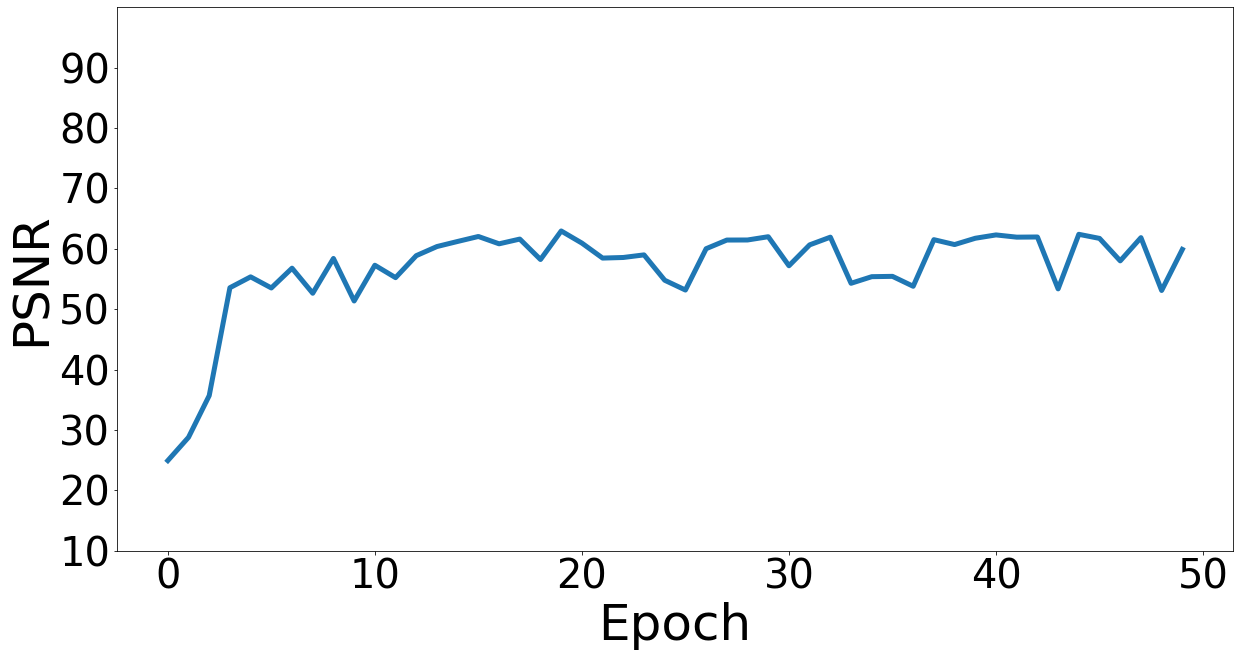

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-IN.pdf')
plt.show()



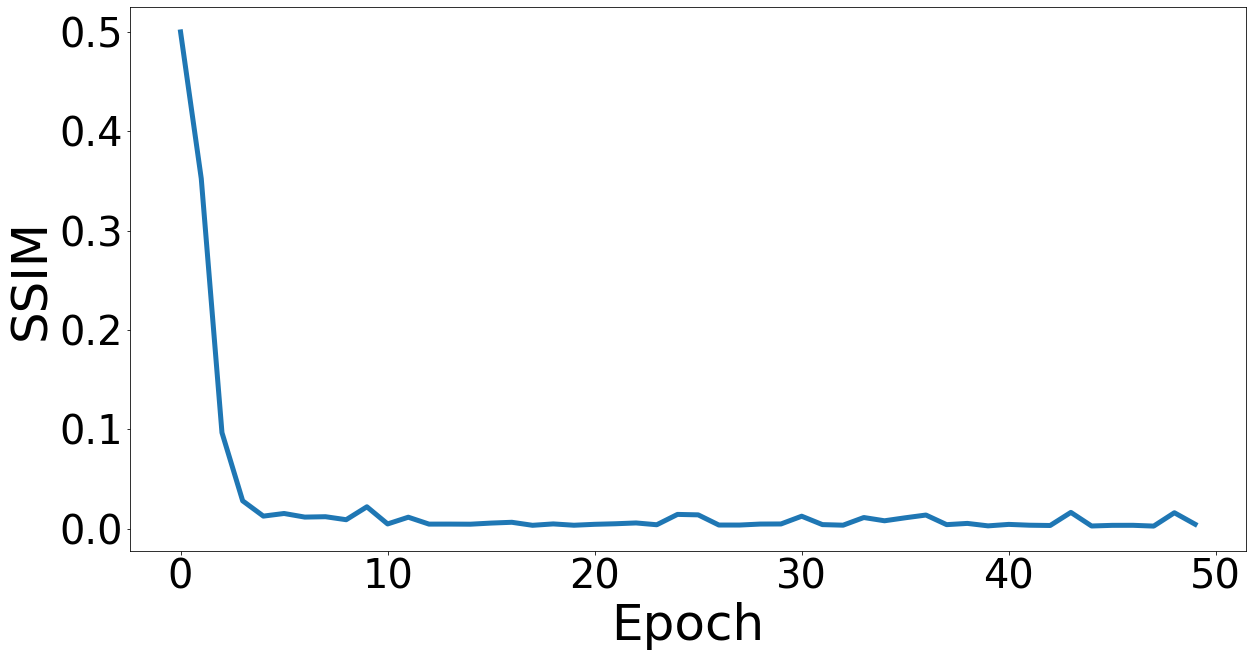

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-IN.pdf')

plt.show()


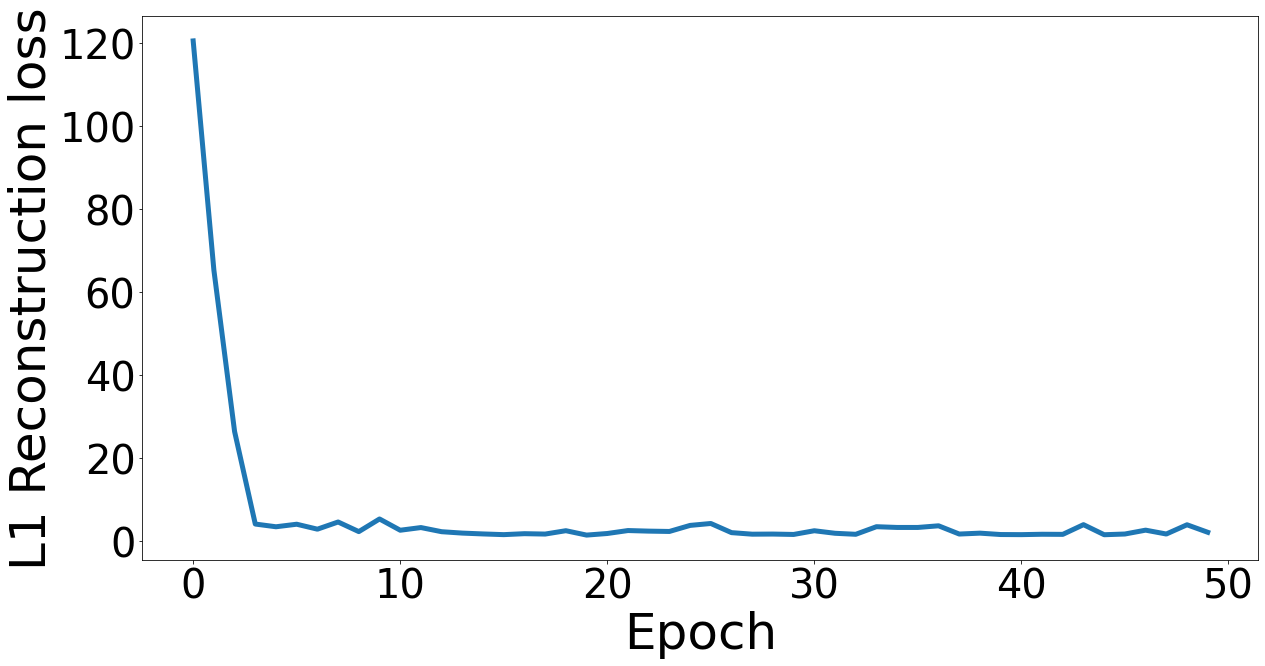

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-IN.pdf')
plt.show()



## Below is SSIM based optimization

In [0]:
#!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git

Cloning into 'pytorch-ssim'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [0]:
#!ls /content/

Indian_pines_corrected.mat  Indian_pines_gt.mat  pytorch-ssim  sample_data


In [0]:
#!cp -r /content/pytorch-ssim/pytorch_ssim/ /content/

In [0]:
"""import skimage
import pytorch_ssim
global bsnlist
ssim_loss = pytorch_ssim.SSIM()
import kornia
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(200)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        ssim_out = -ssim_loss(data, output)
        ssim_value = - ssim_out.item()
        ssim_out.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,200):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % 600 == 0:

                   
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), ssim_value))
            print("PSNR: {}".format(psnr(data,output)))
        
    #ENTROPY/=160
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 100):
    train(epoch)
    """

Train Epoch: 0 [0/10249 (0%)]	Loss: 0.000305
PSNR: 24.99810028076172
Train Epoch: 0 [9600/10249 (94%)]	Loss: 0.000276
PSNR: 24.901641845703125
Top 30 bands with Entropy -> [127, 197, 19, 98, 94, 171, 57, 62, 70, 80, 86, 158, 93, 96, 95, 175, 112, 115, 146, 119, 120, 141, 51, 199, 49, 28, 5, 6, 16, 17]
Train Epoch: 1 [0/10249 (0%)]	Loss: 0.000075
PSNR: 24.865007400512695
Train Epoch: 1 [9600/10249 (94%)]	Loss: 0.000538
PSNR: 25.08080291748047
Top 30 bands with Entropy -> [87, 9, 75, 136, 107, 29, 129, 170, 143, 77, 116, 94, 54, 140, 183, 188, 132, 147, 149, 11, 103, 98, 100, 138, 127, 131, 135, 110, 113, 114]
Train Epoch: 2 [0/10249 (0%)]	Loss: 0.000401
PSNR: 24.898605346679688
Train Epoch: 2 [9600/10249 (94%)]	Loss: 0.000427
PSNR: 24.9992733001709
Top 30 bands with Entropy -> [45, 143, 119, 118, 21, 23, 150, 99, 94, 171, 133, 81, 91, 158, 152, 156, 100, 58, 123, 125, 128, 66, 130, 32, 39, 26, 34, 19, 36, 9]
Train Epoch: 3 [0/10249 (0%)]	Loss: 0.000465
PSNR: 24.939453125
Train Epoch: 3 

# Band MSD and some plots

In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20  
  info_div = 0  
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [0]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [0]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [0]:
dabsrecnet = [154, 12, 112, 88, 133, 127, 158, 13, 113, 51, 152, 125, 30, 58, 126, 168, 95, 32, 75, 31, 82, 22, 142, 86, 123]
bsnetconv = [46,33,140,161,80,35,178,44,126,36,138,71,180,66,192,16,53,152,185,119,24,28,26,156,83]
pca = [167,74,168,0,147,165,161,162,152,19,160,119,164,159,157,163,158,156,20,154,118,148,153,149,155]
spabs = [7, 96, 52, 171, 53, 3, 76, 75, 74, 95, 77, 73, 78, 54, 81,94,88,91,71,72,79,80,55,92,56] 
snmf = [23,197,198,94,76,2,87,105,143,145,11,84,132,108,28,104,144,34,44,74,71,96,75,171,162]


#dabsold = [126, 84, 154, 124, 129, 127, 87, 88, 57, 65, 153, 80, 59, 156, 76, 91, 163, 125, 130, 123, 67, 111, 141, 53, 149]


In [0]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSA(dabsrecnet)
MSA(bsnetconv)
MSA(pca)
MSA(spabs)
MSA(snmf)





[ 6.2730408413107845 , 4.7085535224795105 , 4.183174181057516 , 3.923776833409783 , 3.7677873994952407 , 3.6627284726285714 , 3.5887420429787715 , 3.532705387261601 , 3.48914216633686 , 3.454288031606742 , 3.425823814673791 , 3.402297236247881 , 3.382037557695645 , 3.3651140364717036 , 3.3500917338784926 , 3.337100543545866 , 3.3255588728581333 , 3.315321418652446 , 3.306207595591922 , 3.298045030231039 , 3.2905238931208833 , 3.283715493694796 , 3.277591954970748 ]
[ 6.278871895393927 , 4.704068155502441 , 4.184747558519284 , 3.923707160073312 , 3.767183379028134 , 3.662915647997048 , 3.5886256127024923 , 3.532713500229611 , 3.4890292771788305 , 3.454348698003789 , 3.4259939677377056 , 3.4022369567275508 , 3.382136874337856 , 3.365018280311268 , 3.350087784660422 , 3.33705842384793 , 3.325537357029824 , 3.315365630374464 , 3.306193516939014 , 3.298022607408198 , 3.29051616251832 , 3.2838047497952743 , 3.2776048115017273 ]
[ 6.268593483038058 , 4.705529171043243 , 4.184902965348702 , 3.

In [0]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSD(dabsrecnet)
MSD(bsnetconv)
MSD(pca)
MSD(spabs)
MSD(snmf)
MSD(issc)




[ 33.12881252113703 , 27.699269748852547 , 31.189050523240567 , 25.407158521806743 , 21.23842365661258 , 21.4600299169822 , 20.86248085946583 , 20.17228040657472 , 20.53299041484558 , 21.1335634998955 , 19.59117061832842 , 20.946230004039375 , 22.843494279707382 , 21.596483466175062 , 21.633130554147392 , 22.832050045391185 , 23.112561570936894 , 23.938250673675114 , 24.27697303727743 , 24.67049003424132 , 24.818116958133697 , 24.450204537801287 , 25.019421764795172 ]
[ 24.926582298710684 , 21.330938461786815 , 23.04076040826106 , 21.645181998356264 , 18.691557180047244 , 20.7226257192415 , 20.180950404677475 , 18.92119239091796 , 18.14126793229048 , 18.054941145300337 , 19.2913419518319 , 21.458442690479096 , 22.376986846120094 , 26.539316782854403 , 26.364677531292276 , 26.004356791026886 , 26.06563007931373 , 27.562615680165703 , 26.816233958923476 , 26.75423730463073 , 26.76546728344344 , 26.651876628889074 , 26.170407693767313 ]
[ 64.6659495569616 , 44.206964175291155 , 56.9744050

In [0]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    
EntropySum(dabsrecnet)
EntropySum(bsnetconv)
EntropySum(pca)
EntropySum(spabs)
EntropySum(snmf)
EntropySum(issc)



[ 20.905239036720836 , 31.584922112621634 , 42.308339118118724 , 52.84680178665347 , 63.61131903624624 , 73.16650543923579 , 85.1037122426576 , 96.00913840419082 , 108.39352835503783 , 117.33560179453637 , 128.21321287591948 , 140.40154574243303 , 150.97442231970794 , 161.7691765679261 , 171.11831485205943 , 181.4512615185745 , 193.45796226810216 , 204.16724905851507 , 215.64325461192936 , 226.1965275761768 , 238.3111692727675 , 246.31364854400385 , 256.90988195823275 ]
[ 24.520691123780665 , 34.065954122992856 , 43.699039884997774 , 53.654773803218674 , 65.1226406476009 , 74.1518141539555 , 86.5259165209105 , 97.32067076912867 , 109.18449295051416 , 119.35364059861976 , 131.11656744422467 , 140.01502467765877 , 151.84191948878828 , 159.70287692634798 , 171.70409304075076 , 183.70756668731806 , 192.64964012681662 , 201.16597540913713 , 212.06908126187813 , 224.2696214003704 , 236.5520343202873 , 248.7622041999744 , 257.8314018030394 ]
[ 20.493329325446677 , 29.842467609579998 , 38.9617

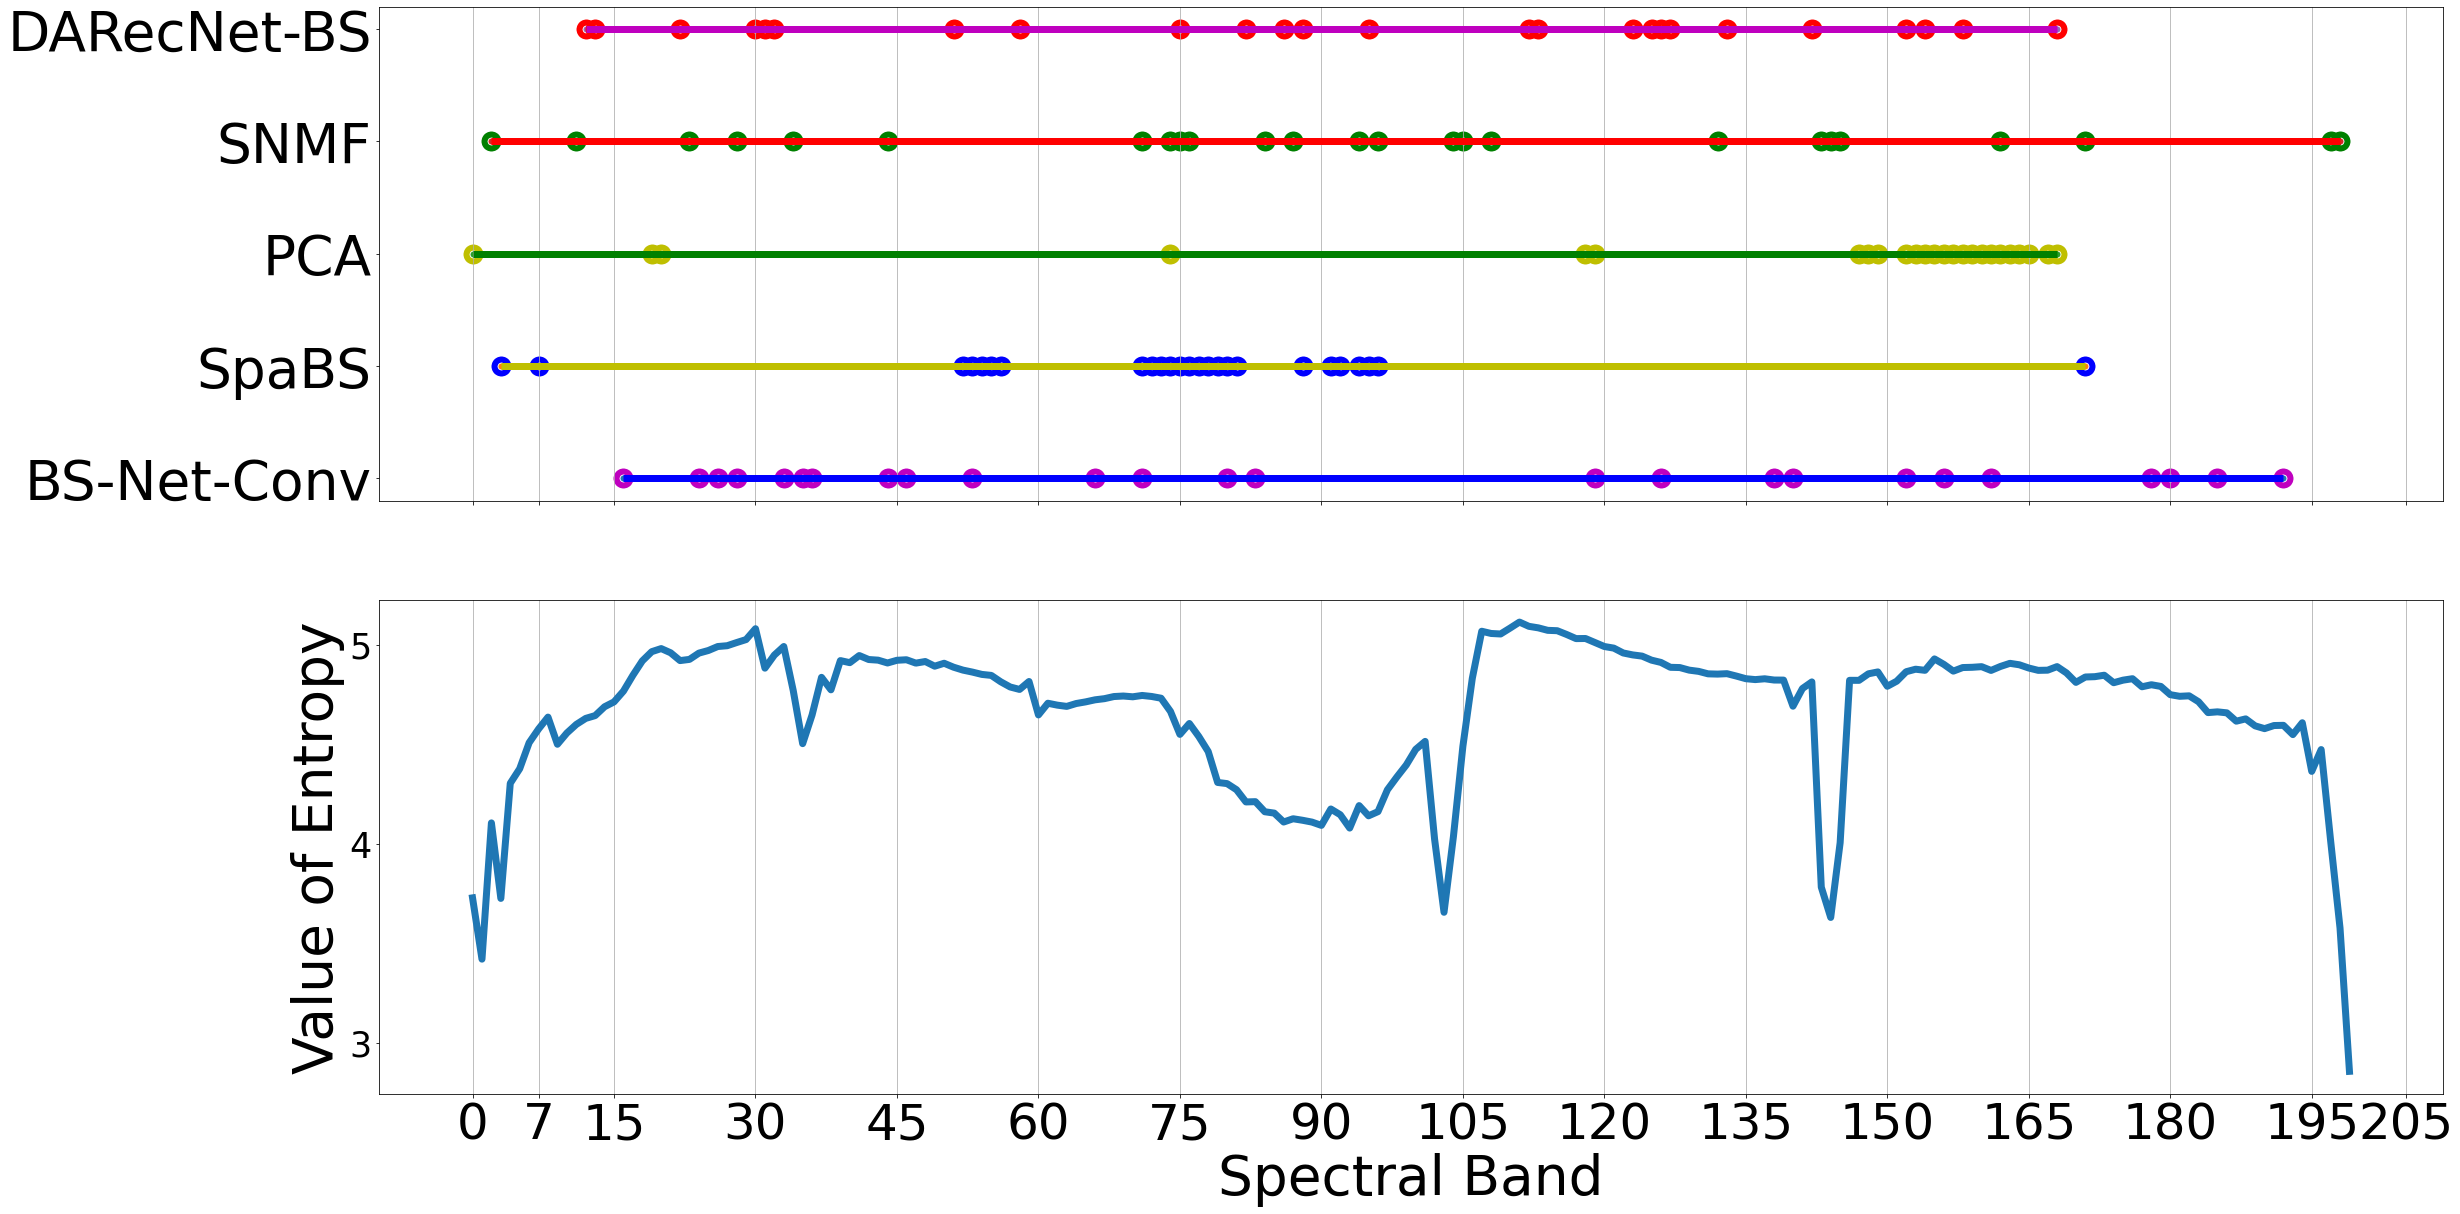

In [0]:
import os
if not (os.path.isfile('/content/IN.csv')):
  !wget https://raw.githubusercontent.com/ucalyptus/Double-Branch-Dual-Attention-Mechanism-Network/master/IN.csv
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/IN.csv")
import matplotlib.pyplot as plt
X, _ = loadData()
n_row,n_column,n_band= X.shape
N = n_row * n_column
hist = []
Entropy  = []
for i in range(n_band):
  hist_, _ = np.histogram(X[:, :, i], 256)
  hist.append(hist_ / N)
  band_i = hist[i].reshape(-1)/np.sum(hist[i])
  entr_i = entropy(band_i)
  Entropy.append(entr_i)
 
for i in range(0,len(df['Selected Bands'])):
  df['Selected Bands'][i] = re.findall('[0-9]+', df['Selected Bands'][i])
  df['Selected Bands'][i] = [int(k) for k in df['Selected Bands'][i]]
meth = ["BS-Net-Conv","SpaBS","PCA","SNMF","DARecNet-BS"]
cols = ['b','y','g','r','m']
fig1,(ax1,ax2) = plt.subplots(2,sharex='col',figsize=(37,20))
ax1.grid(True)
ax1.yaxis.grid(False)
ax1.set_xticks([0,7,15,30,45,60,75,90,105,120,135,150,165,180,195,205])
ax1.yaxis.set_tick_params(labelsize=55)
plt.ylabel(meth)
scatar = []
for i in range(0,len(meth)):
  ax1.hlines(y = meth[i],xmin=min(df['Selected Bands'][i]),xmax=max(df['Selected Bands'][i]),colors=cols[i],linewidth=7)
  SCATTER = ax1.scatter(x=df['Selected Bands'][i],y = [i]*25,edgecolors=cols[i-1],linewidths=14)
  scatar.append(SCATTER)
ax2.grid(True)
ax2.yaxis.grid(False)
ax2.set_yticks([1,2,3,4,5])
ax2.set_ylabel("Value of Entropy",fontsize=55)
ax2.set_xlabel("Spectral Band",fontsize=55)
ax2.xaxis.set_tick_params(labelsize=50)
ax2.yaxis.set_tick_params(labelsize=35)
ax2.plot(Entropy,linewidth=7)
plt.savefig('Entropy_IN.pdf')

